In [1]:
import os
import numpy
import polars as pl
import matplotlib.pyplot as plt
import seaborn
import glob
import pandas as pd
from typing import Dict, List


In [6]:
from os import sep

def load_files_from_directory(
    directory_path: str, 
    file_pattern: str
) -> Dict[str, pl.DataFrame]:
    """
    Loads files matching a specific pattern from a directory using Polars and stores them
    with their base file name (without extension) as the key in a dictionary.
    
    Args:
    - directory_path (str): The directory to scan for files.
    - file_pattern (str): The glob pattern to match files (e.g., '*_10000_*.phased.snpden').

    Returns:
    - Dict[str, pl.DataFrame]: A dictionary with base file names as keys and Polars DataFrames as values.
    """
    loaded_files_dict: Dict[str, pl.DataFrame] = {}
    
    # Use glob to get a list of files matching the pattern
    files: List[str] = glob.glob(os.path.join(directory_path, file_pattern))
    
    if not files:
        print(f"No files matching the pattern '{file_pattern}' were found in the directory '{directory_path}'.")
        return loaded_files_dict

    # Loop through all matching files
    for file in files:
        if os.path.isfile(file):  # Ensure it's a file
            # Extract the base file name (without path and extension)
            file_basename: str = os.path.splitext(os.path.basename(file))[0]

            try:
                # Read the CSV file into a Polars DataFrame
                df: pl.DataFrame = pl.read_csv(file, separator='\t')
                loaded_files_dict[file_basename] = df
            except Exception as e:
                print(f"Error reading {file}: {e}")
                continue
    
    return loaded_files_dict

# Example usage
file_directory: str = "../vcf_stats/"  # Specify the directory
pattern: str = "*_10000_*.phased.snpden"  # Define the file pattern

# Load files based on the pattern
files_data: Dict[str, pl.DataFrame] = load_files_from_directory(file_directory, pattern)
files_data.keys()

Error reading ../vcf_stats/snp_density_10000_sorted_chr_10.phased.snpden: empty CSV


dict_keys(['snp_density_10000_sorted_chr_32.phased', 'snp_density_10000_sorted_chr_24.phased', 'snp_density_10000_sorted_chr_4.phased', 'snp_density_10000_sorted_chr_3.phased', 'snp_density_10000_sorted_chr_2.phased', 'snp_density_10000_sorted_chr_22.phased', 'snp_density_10000_sorted_chr_30.phased', 'snp_density_10000_sorted_chr_26.phased', 'snp_density_10000_sorted_chr_15.phased', 'snp_density_10000_sorted_chr_31.phased', 'snp_density_10000_sorted_chr_Z.phased', 'snp_density_10000_sorted_chr_27.phased', 'snp_density_10000_sorted_chr_5.phased', 'snp_density_10000_sorted_chr_25.phased', 'snp_density_10000_sorted_chr_17.phased', 'snp_density_10000_sorted_chr_14.phased', 'snp_density_10000_sorted_chr_9.phased', 'snp_density_10000_sorted_chr_12.phased', 'snp_density_10000_sorted_chr_16.phased', 'snp_density_10000_sorted_chr_6.phased', 'snp_density_10000_sorted_chr_20.phased', 'snp_density_10000_sorted_chr_29.phased', 'snp_density_10000_sorted_chr_8.phased', 'snp_density_10000_sorted_chr_2

In [24]:
from email.policy import default


def merge_dataframes_from_dict(
    dataframes: Dict[str, pl.DataFrame], 
    first_file_key: str
) -> pl.DataFrame:
    """
    Merges DataFrames stored in a dictionary based on a common column ('CHROM').
    Only the first DataFrame's column names will be preserved.

    Args:
    - dataframes: A dictionary where the keys are file names and the values are DataFrames.
    - first_file_key: The key for the first DataFrame to use as the base for column names.

    Returns:
    - A single merged DataFrame with rows from all DataFrames, retaining the column names of the first DataFrame.
    """
    # Get the first DataFrame from the dictionary
    merged_df: pl.DataFrame = dataframes.get(first_file_key, None)
    
    # Iterate over the rest of the DataFrames and merge them
    for key, df in dataframes.items():
        if key != first_file_key:
            merged_df = merged_df.merge_sorted(df, key="CHROM", )
    
    return merged_df

merged_vcf_stats: pl.DataFrame = merge_dataframes_from_dict(files_data, 'snp_density_10000_sorted_chr_1.phased')
print(merged_vcf_stats.select("CHROM").unique().sort("CHROM"))


shape: (33, 1)
┌────────┐
│ CHROM  │
│ ---    │
│ str    │
╞════════╡
│ chr_1  │
│ chr_11 │
│ chr_12 │
│ chr_13 │
│ chr_14 │
│ …      │
│ chr_6  │
│ chr_7  │
│ chr_8  │
│ chr_9  │
│ chr_Z  │
└────────┘


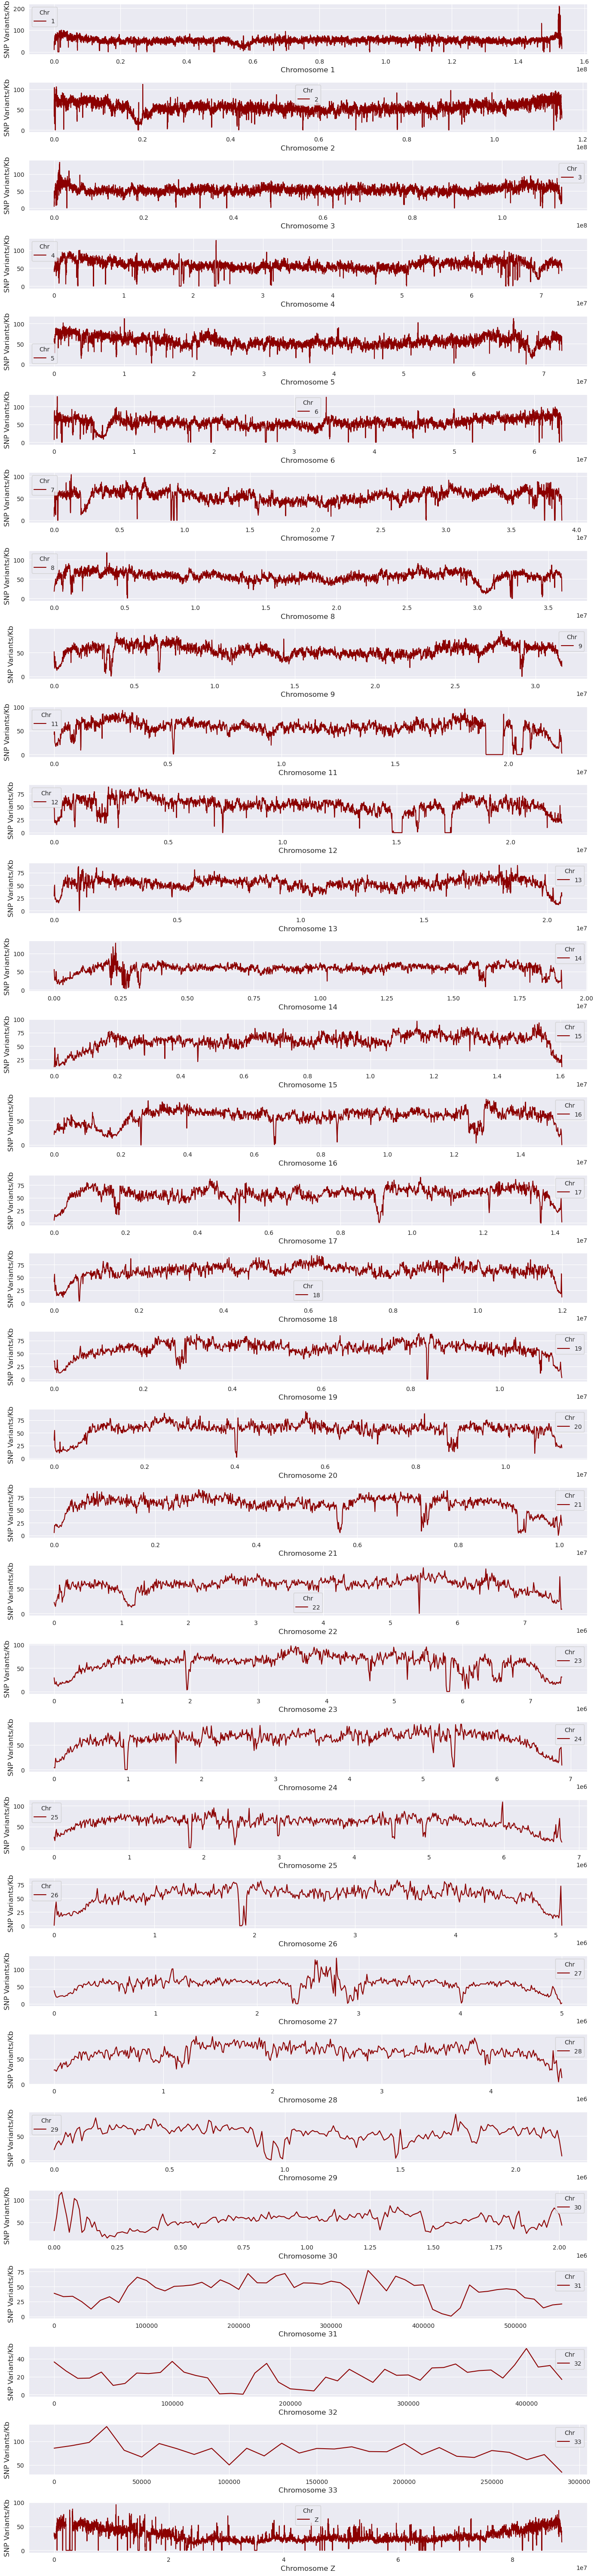

In [ ]:
from cProfile import label
from typing import Union, List
import re

def sort_by_chromosome(dataFrame: pl.DataFrame) -> pl.DataFrame:
    
    dataFrame = dataFrame.with_columns([
        pl.col("CHROM")
        .str.extract(r"(\d+)$")
        .cast(pl.Int32)
        .alias("CHROM_NUM")
    ])
    
    dataFrame = dataFrame.sort("CHROM_NUM")
    
    return dataFrame.drop("CHROM_NUM")
sorted_vcf_stats = sort_by_chromosome(merged_vcf_stats)


def chrom_to_sortable(chrom: str) -> Union[int, float]:
    chrom = chrom.lower().replace("chr_", "").replace("chr", "")
    if chrom.isdigit():
        return int(chrom)
    elif chrom == "w":
        return 34
    elif chrom == "z":
        return 35
    else:
        return float("inf")
    

def chrom_numeric_label(chrom: str) -> Union[str, int]:
    """Map 'chr_X' -> 'X', 'chr_1' -> 1, etc. for clean display."""
    chrom = chrom.lower().replace("chr_", "").replace("chr", "")
    return chrom.upper() if not chrom.isdigit() else int(chrom)
         
def plot_chromosome_density(dataFrame: pl.DataFrame):
    pandas_dataFrame: pd.DataFrame = dataFrame.to_pandas()

    # Extract sortable chromosome order and clean display label
    pandas_dataFrame["CHROM_SORT"] = pandas_dataFrame["CHROM"].apply(chrom_to_sortable)
    pandas_dataFrame["CHROM_LABEL"] = pandas_dataFrame["CHROM"].apply(chrom_numeric_label)

    seaborn.set_style("darkgrid")
    
    # Sort chromosomes by the sortable value
    chromosomes = pandas_dataFrame.drop_duplicates(subset="CHROM").sort_values("CHROM_SORT")

    fig, axes = plt.subplots(len(chromosomes), 1, figsize=(14, min(6 * len(chromosomes), 60)))

    if len(chromosomes) == 1:
        axes = [axes]

    for i, (_, row) in enumerate(chromosomes.iterrows()):
        chrom_label = row["CHROM_LABEL"]
        chrom_sort_val = row["CHROM_SORT"]
        chrom_orig = row["CHROM"]
        chromosome_data = pandas_dataFrame[pandas_dataFrame["CHROM"] == chrom_orig]

        seaborn.lineplot(
            data=chromosome_data,
            x="BIN_START",
            y="VARIANTS/KB",
            color="darkred",
            ax=axes[i],
            label=str(chrom_label)
        )
        axes[i].set_xlabel(f"Chromosome {chrom_label}", fontsize=12)
        axes[i].set_ylabel("SNP Variants/Kb", fontsize=12)

    plt.tight_layout()
    plt.show()
    

plot_chromosome_density(sorted_vcf_stats)